In [2]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd
from sklearn import mixture
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.special import softmax
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from microfilm.colorify import multichannel_to_rgb
from sklearn.cluster import AgglomerativeClustering
import multiscale_phate
import scprep

In [3]:
imsize = 512
batch_size = 10
# DATA_DIR = Path("./dev-dataset-FUCCI/")
# DATA_DIR = Path("/data/ishang/FUCCI-data/")
DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# NAME = "native_res_512_min_max"
# NAME = "native_res_512_min_max_low_sharp"
NAME = "well_spline_norm_512_crop_sharpness_1250"

In [3]:

# RGB_DATASET = DATA_DIR / "rgb_native_res_512_min_max.pt"
# dataset = SimpleDataset(path=RGB_DATASET)
# dataset = CellImageDataset(DATA_DIR / "index_rgb_native_res_512_min_max.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])

dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"], batch_size=batch_size)


Loading dataset images:  80%|████████  | 12/15 [02:31<00:37, 12.62s/it]


KeyboardInterrupt: 

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

# OLD PSEUDOTIMEEEE

In [ ]:
FUCCI_mean_intensities = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_mean_intensities.append(torch.mean(batch[:, 2:], dim=(2, 3)))
FUCCI_mean_intensities = torch.cat(FUCCI_mean_intensities, dim=0)

In [ ]:
print(torch.isnan(FUCCI_mean_intensities).sum())
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 0]), 0])))
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 1]), 1])))
print(len(FUCCI_mean_intensities))

In [ ]:
log_min = torch.tensor([10 ** (-5.4), 10 ** (-5)])
FUCCI_log_mean_intensities = torch.log10(FUCCI_mean_intensities + (~(FUCCI_mean_intensities > 0)) * log_min)
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.isnan(FUCCI_log_mean_intensities).sum())
print(len(FUCCI_log_mean_intensities))

In [ ]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

Here GMNN has 10^4-fold meaningful range, whereas CDT1 has about 10^3-fold.

In [ ]:
# FUCCI_log_mean_intensities_rescaled = FUCCI_log_mean_intensities * torch.tensor([1.0, 4/3])
# pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_rescaled.numpy(), columns=['GMNN', 'CDT1'])
# sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

In [ ]:
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')
outliers_index = ((pseudo_time_df['GMNN'] < -2.6) & (pseudo_time_df['CDT1'] < -2.7) | (pseudo_time_df['GMNN'] < -4.5) | (pseudo_time_df['CDT1'] < -4))
outlier = pseudo_time_df[outliers_index]
sns.scatterplot(data=outlier, x='GMNN', y='CDT1')

In [ ]:
print(np.sum(outliers_index) / len(outliers_index))
print(torch.min(FUCCI_log_mean_intensities[:, 0]), torch.max(FUCCI_log_mean_intensities[:, 0]))
print(torch.min(FUCCI_log_mean_intensities[:, 1]), torch.max(FUCCI_log_mean_intensities[:, 1]))

So 3.36% of the data is outside the range we really see in the KDE plots

In [ ]:
# cdts = range(-1, -8, -0.5) # so the grid with go top to bottom,
cdts = np.linspace(-0.3, -5, 20)
# gmmns = range(-5, 0, 0.5) # left to right
gmnns = np.linspace(-5.3, -0.3, 20)
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)


grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)
plt.figure(figsize=(15, 15))
plt.imshow(grid)

In [ ]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

In [ ]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

![pseudotime](./pseudotime.png)

Based on this the phases of the cell in these data are:

Top Left Mode: G1

Middle Mode: G1/S

Top Right Top: S

Top Right Bottom: G2

Dead Bottom (minimum CDT): M

In [ ]:
n_components, prior = 4, 1e-5
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
# from sklearn.decomposition import NMF
# nmf = NMF(n_components=2)
# X_train_nmf = nmf.fit_transform(X_train * -1)
# clf_cc_3_weight.fit(X_train_nmf)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
# sns.jointplot(x=X_train_nmf[:, 0], y=X_train_nmf[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
w = clf_cc.weights_
print(w[1], w[2], w[0], w[3])

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=6).fit(X_train)
sns.jointplot(x=X_train[:,0], y=X_train[:,1], hue=clustering.labels_, palette="Set2")

In [ ]:
order = [4, 2, 0, 5, 1, 3]
for i in order:
    print(np.sum(clustering.labels_ == i) / len(clustering.labels_))

In [ ]:
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

![pseudoints](./pseudo_ints.png)
![system](./system.png)

From the images below, we might expect the following proportions:

M: 3; M/G1:6 + G1: 29; G1/S: 7; S:16, G2: 15

So M: 3; G1:35; S:23; G2:15 or 4%, 45%, 30%, 20% (which makes sense given the breakdown above)

That means the GMM above primarily over-estimates S and underestimates G1, which is strangely paralleled by the DINO model

![progpics](./prog_pics.png)

In [ ]:
clf_cc = mixture.GaussianMixture(n_components=3, weights_init=(0.5, 0.3, 0.2), n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
y = clf_cc.predict_proba(X_pred)
y = y / np.sum(y, axis=-1, keepdims=True)
# y = softmax(y / 3, axis=-1)
plt.scatter(X_pred[:10000, 0], X_pred[:10000, 1], c=y[:10000])

In [ ]:
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
clf_cc_5 = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
clf_cc_5.fit(X_train)
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
y = clf_cc_5.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

# NEW PSEUDOTIME METHOD HEREEERERERE

In [ ]:
FUCCI_nonzero_pixel_ct = []
FUCCI_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_intensity_sums.append(torch.sum(batch[:, 2:], dim=(2, 3)))
    FUCCI_nonzero_pixel_ct.append(torch.sum(batch[:, 2:] > 0, dim=(2, 3)))
FUCCI_intensity_sums = torch.cat(FUCCI_intensity_sums, dim=0)
FUCCI_nonzero_pixel_ct = torch.cat(FUCCI_nonzero_pixel_ct, dim=0)

In [ ]:
def two_sig_fig_floor(x):
    return torch.floor(x / torch.pow(10.0, torch.floor(torch.log10(x)) - 1)) * torch.pow(10.0, torch.floor(torch.log10(x)) - 1)

print("Number of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_nonzero_pixel_ct[:, 0]), torch.max(FUCCI_nonzero_pixel_ct[:, 0]))
print(torch.min(FUCCI_nonzero_pixel_ct[:, 1]), torch.max(FUCCI_nonzero_pixel_ct[:, 1]))

print("\nNumber of nonzero cells, min with and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_nonzero_pixel_ct[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_nonzero_pixel_ct[:, 1].nonzero().flatten()

print(torch.min(FUCCI_nonzero_pixel_ct[nonzero_0, 0]), torch.min(FUCCI_nonzero_pixel_ct[:, 0]))
print(torch.min(FUCCI_nonzero_pixel_ct[nonzero_1, 1]), torch.min(FUCCI_nonzero_pixel_ct[:, 1]))
FUCCI_nonzero_ct_eps = torch.tensor([torch.min(FUCCI_nonzero_pixel_ct[nonzero_0, 0]), torch.min(FUCCI_nonzero_pixel_ct[nonzero_1, 1])])
FUCCI_nonzero_ct_eps = two_sig_fig_floor(FUCCI_nonzero_ct_eps)
print("eps: ", FUCCI_nonzero_ct_eps)

print("\nIntensity of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_intensity_sums[:, 0]), torch.max(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[:, 1]), torch.max(FUCCI_intensity_sums[:, 1]))

print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_intensity_sums[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_intensity_sums[:, 1].nonzero().flatten()

print(torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[nonzero_1, 1]), torch.min(FUCCI_intensity_sums[:, 1]))
FUCCI_sum_eps = torch.tensor([torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[nonzero_1, 1])])
FUCCI_sum_eps = two_sig_fig_floor(FUCCI_sum_eps)
print("eps: ", FUCCI_sum_eps)

In [ ]:
FUCCI_log_mean_intensities_nonzero = torch.log10((FUCCI_intensity_sums + FUCCI_sum_eps) / (FUCCI_nonzero_pixel_ct + FUCCI_nonzero_ct_eps))
for i in range(FUCCI_log_mean_intensities_nonzero.shape[1]):
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 0]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 0]))
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 1]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 1]))

In [ ]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_nonzero.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind="kde")

In [ ]:
labels = torch.clone(FUCCI_log_mean_intensities_nonzero)
labels_color = torch.pow(torch.ones_like(labels) * 10, labels)
labels_color = labels_color.transpose(0, 1)
labels_color = torch.stack([labels_color[0], labels_color[1], torch.zeros_like(labels_color[0])])
labels_color = labels_color.transpose(0, 1)

# get the grid
grid_size = 10
grid_x = torch.linspace(labels[:, 0].max(), labels[:, 0].min(), grid_size)
grid_y = torch.linspace(labels[:, 1].min(), labels[:, 1].max(), grid_size)
grid_x, grid_y = torch.meshgrid(grid_x, grid_y)
grid = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

# get the average residual for each grid square
grid_residuals = torch.zeros([grid.shape[0], 3])
for i, point in enumerate(grid):
    # get the points in the grid square
    x_min, x_max = point[0] - 0.5, point[0] + 0.5
    y_min, y_max = point[1] - 0.5, point[1] + 0.5
    mask = (labels[:, 0] >= x_min) & (labels[:, 0] < x_max) & (labels[:, 1] >= y_min) & (labels[:, 1] < y_max)
    if mask.sum() == 0:
        grid_residuals[i] = torch.ones_like(grid_residuals[i])
    else:
        grid_residuals[i] = torch.mean(preds_color[mask], dim=0)
grid_residuals = grid_residuals.reshape(grid_size, grid_size, 3)
grid_residuals = torch.clamp(grid_residuals, 0, 1) * 255

# plot the heatmap
plt.imshow(grid_residuals.int())

In [ ]:
# write the intensity labels to file

np.save(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy", FUCCI_log_mean_intensities_nonzero.numpy())

In [ ]:
# similarly calculate intensities of input reference channels
REF_nonzero_pixel_ct = []
REF_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    REF_intensity_sums.append(torch.sum(batch[:, :2], dim=(2, 3)))
    REF_nonzero_pixel_ct.append(torch.sum(batch[:, :2] > 0, dim=(2, 3)))
REF_intensity_sums = torch.cat(REF_intensity_sums, dim=0)
REF_nonzero_pixel_ct = torch.cat(REF_nonzero_pixel_ct, dim=0)

In [ ]:
nonzero_0 = REF_nonzero_pixel_ct[:, 0].nonzero().flatten()
nonzero_1 = REF_nonzero_pixel_ct[:, 1].nonzero().flatten()

REF_nonzero_ct_eps = torch.tensor([torch.min(REF_nonzero_pixel_ct[nonzero_0, 0]), torch.min(REF_nonzero_pixel_ct[nonzero_1, 1])])
REF_nonzero_ct_eps = two_sig_fig_floor(REF_nonzero_ct_eps)

nonzero_0 = REF_intensity_sums[:, 0].nonzero().flatten()
nonzero_1 = REF_intensity_sums[:, 1].nonzero().flatten()

REF_sum_eps = torch.tensor([torch.min(REF_intensity_sums[nonzero_0, 0]), torch.min(REF_intensity_sums[nonzero_1, 1])])
REF_sum_eps = two_sig_fig_floor(REF_sum_eps)

In [ ]:
REF_log_mean_intensities_nonzero = torch.log10((REF_intensity_sums + REF_sum_eps) / (REF_nonzero_pixel_ct + REF_nonzero_ct_eps))
for i in range(REF_log_mean_intensities_nonzero.shape[1]):
    print(len(REF_log_mean_intensities_nonzero[torch.isnan(REF_log_mean_intensities_nonzero[:, i])]),
        REF_log_mean_intensities_nonzero[torch.isnan(REF_log_mean_intensities_nonzero[:, i])][:10, i])
    print(len(REF_log_mean_intensities_nonzero[torch.isinf(REF_log_mean_intensities_nonzero[:, i])]),
        REF_log_mean_intensities_nonzero[torch.isinf(REF_log_mean_intensities_nonzero[:, i])][:10, i])
print(torch.min(REF_log_mean_intensities_nonzero[:, 0]), torch.max(REF_log_mean_intensities_nonzero[:, 0]))
print(torch.min(REF_log_mean_intensities_nonzero[:, 1]), torch.max(REF_log_mean_intensities_nonzero[:, 1]))

In [ ]:
# plot reference intensity sum against FUCCI intensity sum
plt.scatter(torch.sum(REF_log_mean_intensities_nonzero, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
# add a line of best fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(torch.sum(REF_log_mean_intensities_nonzero, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
print(slope, intercept, r_value, p_value, std_err)
plt.plot(torch.sum(REF_log_mean_intensities_nonzero, dim=1), intercept + slope * torch.sum(REF_log_mean_intensities_nonzero, dim=1), 'r', label='fitted line')

In [ ]:
# KDE plot of reference intensity sum against FUCCI intensity sum
sns.kdeplot(x=torch.sum(REF_log_mean_intensities_nonzero, dim=1), y=torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))

In [ ]:
FUCCI_intensity_sums_corrected = FUCCI_intensity_sums + FUCCI_sum_eps
REF_intensity_sums_corrected = REF_intensity_sums + REF_sum_eps
# plot reference intensity sum against FUCCI intensity sum
plt.scatter(torch.sum(REF_intensity_sums_corrected, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
# add a line of best fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(torch.sum(REF_intensity_sums_corrected, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
print(slope, intercept, r_value, p_value, std_err)
plt.plot(torch.sum(REF_intensity_sums_corrected, dim=1), intercept + slope * torch.sum(REF_intensity_sums_corrected, dim=1), 'r', label='fitted line')

In [ ]:
# write reference intensities to file
np.save(DATA_DIR / f"REF_log_intensity_labels_{NAME}.npy", REF_log_mean_intensities_nonzero.numpy())

# PHATE

In [ ]:
def PHATE_fit(embeddings, sample=None, message=""):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if sample is not None:
        indices = np.random.choice(len(embeddings), sample)
        embeddings = embeddings[indices]
    mp_op = multiscale_phate.Multiscale_PHATE()
    return mp_op.fit_transform(embeddings)

def PHATE_plot(mp_embedding, mp_sizes, mp_clusters, message=""):
    scprep.plot.scatter2d(mp_embedding, s=mp_sizes, c=mp_clusters,
                          fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10, 10))

In [ ]:
phate_output = PHATE_fit(FUCCI_log_mean_intensities_nonzero, sample=1000)
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(FUCCI_log_mean_intensities_nonzero)
PHATE_plot(*phate_output, message="")

# Mosaic

In [ ]:
cdts = np.linspace(0.0, -3.0, 20) # so the grid with go top to bottom,
gmnns = np.linspace(-3.0, 0.0, 20) # left to right
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities_nonzero - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)

grid = make_grid(images, nrow=nrow)
print(grid.shape)

In [ ]:
xlabels = np.round(gmnns[::2], 1)
xticks = (gmnns[::2] - np.min(gmnns)) / (np.max(gmnns) - np.min(gmnns)) * grid.shape[1]
print(xticks)
print(xlabels)
ylabels = np.round(cdts[::2], 1)
yticks = (cdts[::-2] - np.min(cdts)) / (np.max(cdts) - np.min(cdts)) * grid.shape[2]
print(yticks)
print(ylabels)

In [ ]:

cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)

plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

In [ ]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

In [ ]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

# GMM

In [ ]:
n_components = 3
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.GaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
n_components, prior = 7, 1e-3
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
# import pickle
# GMM_FILE = DATA_DIR / "gmm.pkl"
# pickle.dump(clf_cc, open(GMM_FILE, "wb"))

In [ ]:
# clf_cc_pts = mixture.BayesianGaussianMixture(n_components=6, n_init=10, weight_concentration_prior=1e-4).fit(X_train)

# New datasets

In [ ]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(FUCCI_log_mean_intensities_nonzero)
y_pred = clustering.labels_


In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:,0], y=FUCCI_log_mean_intensities_nonzero[:,1], hue=y_pred, palette='Set2')

# convert y_pred to torch tensor and write to DATA_DIR / "ward_probs_{name}.pt"
y_pred = torch.tensor(y_pred)
print(y_pred.shape)

print(torch.unique(y_pred))

In [ ]:
remap = [2, 1, 3, 0]
print(y_pred[:10])
y_pred_remapped = []
for i in range(len(y_pred)):
    y_pred_remapped.append(remap.index(y_pred[i]))
print(y_pred_remapped[:10])

In [ ]:
file_name = DATA_DIR / f"ward_{n_clusters}_probs_{NAME}.pt"
y_pred_remapped = torch.tensor(y_pred_remapped)
torch.save(y_pred_remapped, file_name)
print(f"Saved to {file_name}")

In [ ]:
# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# fit an ellipse to the means and plot
# print(clf_cc_pts.weights_)
# means = clf_cc_pts.means_
# means = np.concatenate((means, np.array([[-2.3, -2.3]])))


means = []
for i in range(n_clusters):
    print(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :].shape)
    means.append(torch.mean(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :], dim=0).cpu().numpy())
means = np.array(means)
means = np.concatenate((means, np.array([[-2.5, -2.3]])))

# Extract x coords and y coords of the ellipse as column vectors
X = means[:,0:1]
Y = means[:,1:2]
# X = X_train[:, 0:1]
# Y = X_train[:, 1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,0]),torch.max(FUCCI_log_mean_intensities_nonzero[:,0]),300)
y_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,1]),torch.max(FUCCI_log_mean_intensities_nonzero[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=means[:, 0], y=means[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

In [ ]:
gmnn_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 0:1])
cdt_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 1:2])

In [ ]:
gmnn_modes = np.stack([gmnn_gmm.means_.flatten(), gmnn_gmm.weights_.flatten()], axis=-1)
gmnn_modes = gmnn_modes[gmnn_modes[:, 0].argsort()]
cdt_modes = np.stack([cdt_gmm.means_.flatten(), cdt_gmm.weights_.flatten()], axis=-1)
cdt_modes = cdt_modes[cdt_modes[:, 0].argsort()]

In [ ]:
points = np.array([
    [0, 0],
    [0, 1],
    [1, 2],
    [1, 2],
    [2, 2],
    [2, 1],
    [2, 0],
])

key_points = np.asarray([[gmnn_modes[:, 0][i], cdt_modes[:, 0][j]] for (i, j) in points])
probs = np.asarray([[gmnn_modes[:, 1][i] * cdt_modes[:, 1][j] for j in range(3)] for i in range(3)])
key_probs = np.asarray([gmnn_modes[:, 1][i] * gmnn_modes[:, 1][j] for (i, j) in points])
key_probs = key_probs / np.sum(key_probs)
print(key_probs)

# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# Extract x coords and y coords of the ellipse as column vectors
X = key_points[:,0:1]
Y = key_points[:,1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(X_train[:,0]),torch.max(X_train[:,0]),300)
y_coord = np.linspace(torch.min(X_train[:,1]),torch.max(X_train[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=key_points[:, 0], y=key_points[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

# Model Prediction Breakdown

In [ ]:
from models import ClassifierLit
from data import DinoRefToCC
data_dir = DATA_DIR
data_name = NAME
ward = True
num_classes = 4
dino_ds = DinoRefToCC(data_dir, data_name, ward, num_classes)


In [ ]:
phate_output = PHATE_fit(dino_ds[:1000][0])
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(dino_ds[:10000][0])
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(dino_ds[:][0])
PHATE_plot(*phate_output, message="")

In [ ]:
import umap
import umap.plot

indices = np.random.choice(len(dino_ds), 5000, replace=False)
embeddings, ps_labels = dino_ds[indices]
ps_labels = torch.argmax(ps_labels, dim=-1).flatten()
umap_embedding = umap.UMAP().fit(embeddings)
umap.plot.points(umap_embedding, labels=ps_labels)

In [ ]:
ckpt_path = Path("/data/ishang/fucci_vae/FUCCI_dino_classifier_ward_2023_08_10_07_50/lightning_logs/99-1.22.ckpt")
model = ClassifierLit.load_from_checkpoint(ckpt_path)

In [ ]:
y_preds = []
batch_size = 100
# device = model.device
model = model.to("cpu")
for i in tqdm(range(0, len(dino_ds), batch_size)):
    x, _ = dino_ds[i:i+batch_size]
    # x = x.to(device)
    y_pred = model(x)
    # y_pred = y_pred.cpu()
    y_preds.append(y_pred)
    # x = x.cpu()
y_preds = torch.cat(y_preds, dim=0)

In [ ]:
# preds_file = "/data/ishang/FUCCI-dataset/native_res_512_min_max_pred_FUCCI_dino_classifier_ward_6_2023_08_10_00_33.pt"
# y_prob = torch.load(preds_file)
# y_pred = torch.argmax(y_prob, dim=1).flatten()
y_pred = torch.argmax(y_preds, dim=1).flatten()
print(torch.unique(y_pred))
# map = [1, 0, 5, 3, 2, 4]
# map = [0, 2, 1]
# y_pred_remap = torch.tensor([map[i] for i in y_pred])
y_pred_remap = torch.tensor([i for i in y_pred])

In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1],
              hue=y_pred_remap, palette="Set2")

In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1],
              hue=y_pred_remap, palette="Set2", kind="kde")

# CCNB1

In [13]:
data_dir = Path("/data/ishang/CCNB1-dataset/")
data_name = "256_res_768_crop_min_max"
# ward = True
# num_classes = 4
# dino_ds = DinoRefToCC(data_dir, data_name, ward, num_classes)
ccnb1_ds = CellImageDataset(data_dir / f"index_{data_name}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green"])

Loading dataset images:   0%|          | 0/4 [00:00<?, ?it/s]

Loading dataset images: 100%|██████████| 4/4 [00:46<00:00, 11.65s/it]

Loaded 32092 images from 1713 files.


In [14]:
dataloader = DataLoader(ccnb1_ds, batch_size=100, shuffle=False, num_workers=4)

In [15]:
CCNB1_nonzero_pixel_ct = []
CCNB1_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    CCNB1_intensity_sums.append(torch.sum(batch[:, 2:3], dim=(2, 3)))
    CCNB1_nonzero_pixel_ct.append(torch.sum(batch[:, 2:3] > 0, dim=(2, 3)))
CCNB1_intensity_sums = torch.cat(CCNB1_intensity_sums, dim=0)
CCNB1_nonzero_pixel_ct = torch.cat(CCNB1_nonzero_pixel_ct, dim=0)

Computing mean intensities: 100%|██████████| 321/321 [00:32<00:00,  9.80it/s]


tensor(5.5213) tensor(21740.6113)
tensor(798) tensor(63403)


tensor(0.0036) tensor(0.6493)


<Axes: ylabel='Count'>

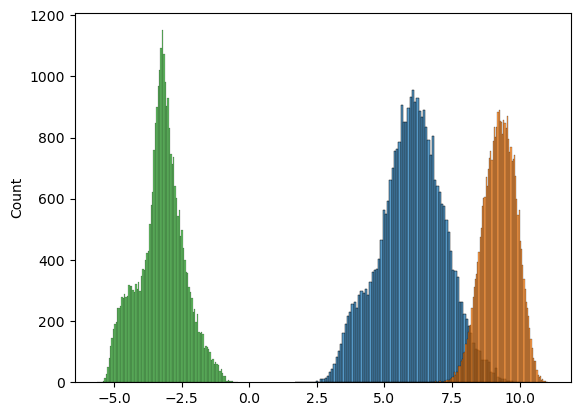

In [23]:
print(torch.min(CCNB1_intensity_sums[:, 0]), torch.max(CCNB1_intensity_sums[:, 0]))
sns.histplot(torch.log(CCNB1_intensity_sums[:, 0]), bins=100)

print(torch.min(CCNB1_nonzero_pixel_ct[:, 0]), torch.max(CCNB1_nonzero_pixel_ct[:, 0]))
sns.histplot(torch.log(CCNB1_nonzero_pixel_ct[:, 0]), bins=100)

CCNB1_average_intensity = CCNB1_intensity_sums / CCNB1_nonzero_pixel_ct
print(torch.min(CCNB1_average_intensity[:, 0]), torch.max(CCNB1_average_intensity[:, 0]))
sns.histplot(torch.log(CCNB1_average_intensity[:, 0]), bins=100)

In [18]:
print("Number of nonzero pixels, min/max")
print(torch.min(CCNB1_nonzero_pixel_ct[:, 0]), torch.max(CCNB1_nonzero_pixel_ct[:, 0]))

print("\nNumber of nonzero pixels, min with and min without looking at images with 0 nonzero pixels")
nonzero_0 = CCNB1_nonzero_pixel_ct[:, 0].nonzero().flatten()

print(torch.min(CCNB1_nonzero_pixel_ct[nonzero_0, 0]), torch.min(CCNB1_nonzero_pixel_ct[:, 0]))
FUCCI_nonzero_ct_eps = torch.tensor([torch.min(CCNB1_nonzero_pixel_ct[nonzero_0, 0])])
FUCCI_nonzero_ct_eps = two_sig_fig_floor(FUCCI_nonzero_ct_eps)
print("eps: ", FUCCI_nonzero_ct_eps)

print("\nIntensity of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(CCNB1_intensity_sums[:, 0]), torch.max(CCNB1_intensity_sums[:, 0]))

print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = CCNB1_intensity_sums[:, 0].nonzero().flatten()

print(torch.min(CCNB1_intensity_sums[nonzero_0, 0]), torch.min(CCNB1_intensity_sums[:, 0]))
FUCCI_sum_eps = torch.tensor([torch.min(CCNB1_intensity_sums[nonzero_0, 0])])
FUCCI_sum_eps = two_sig_fig_floor(FUCCI_sum_eps)
print("eps: ", FUCCI_sum_eps)

Number of nonzero pixels, min/max
tensor(798) tensor(63403)

Number of nonzero pixels, min with and min without looking at images with 0 nonzero pixels
tensor(798) tensor(798)


NameError: name 'two_sig_fig_floor' is not defined

# PSEUDOTIME

In [6]:
# x (index 0) is GMNN, y (index 1) is CDT1
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")

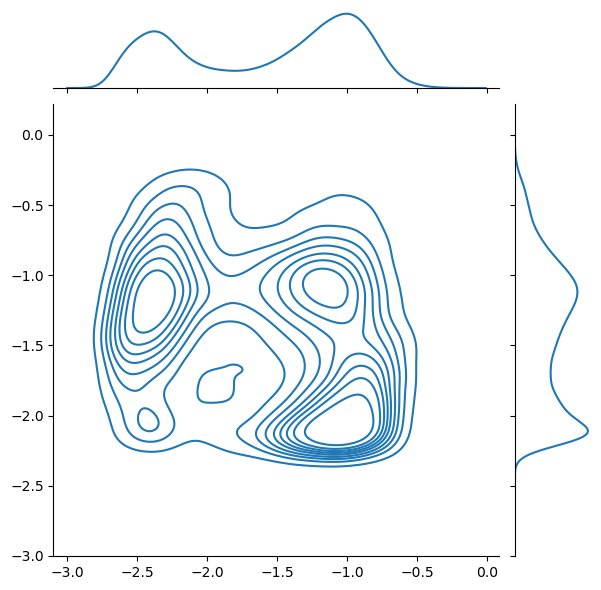

In [7]:
sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")

In [8]:
# find the center of mass of the data
# TODO: why did they use "non-linear least squares"
center = np.mean(log_intensities, axis=0)
# center = np.array([-1.9, -1.8])
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=3, random_state=0).fit(log_intensities)
# center = np.mean(kmeans.cluster_centers_, axis=0)
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(center[0], center[1], c="r")
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="b")
# like kmeans but with a GMM
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=3, random_state=0).fit(log_intensities)
# center = np.mean(gmm.means_, axis=0)
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(center[0], center[1], c="r")
# plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c="b")
print(center)

[-1.5790596 -1.4372873]


In [9]:
from cc_pseudotime import f_2
from scipy.optimize import least_squares

center_estimate = np.mean(log_intensities, axis=0)
print(center_estimate)
center_est2 = least_squares(f_2, center_estimate, args=(log_intensities[:, 0], log_intensities[:, 1]))
print(center_est2.x)
center = center_est2.x

[-1.5790596 -1.4372873]
[-1.5790596  -1.43728733]
[-1.5796048  -1.43728733]
[-1.5790596  -1.43778358]
[-1.67032686 -1.48278463]
[-1.67090357 -1.48278463]
[-1.67032686 -1.48329658]
[-1.68890285 -1.49759379]
[-1.68948597 -1.49759379]
[-1.68890285 -1.49811086]
[-1.69238358 -1.50148478]
[-1.69296791 -1.50148478]
[-1.69238358 -1.5020032 ]


[-1.69303663 -1.50242472]
[-1.69362118 -1.50242472]
[-1.69303663 -1.50294346]
[-1.69316399 -1.50264693]
[-1.69374858 -1.50264693]
[-1.69316399 -1.50316574]
[-1.6931899  -1.50269926]
[-1.69317057 -1.50265996]
[-1.69316565 -1.50265018]
[-1.6931644  -1.50264774]
[-1.69316409 -1.50264713]
[-1.69316401 -1.50264698]
[-1.69316399 -1.50264694]
[-1.69316399 -1.50264693]


In [10]:
# recenter data
centered_intensities = log_intensities - center

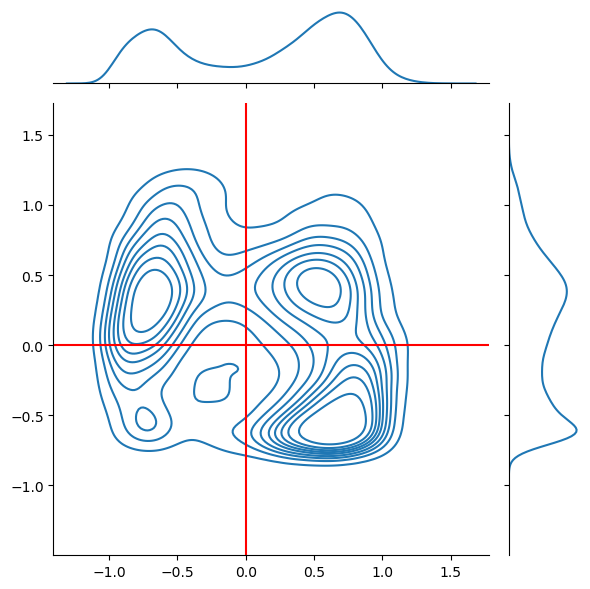

In [11]:
# plot data with axes shown
sns.jointplot(x=centered_intensities[:, 0], y=centered_intensities[:, 1], kind='kde', palette="Set2")
plt.axvline(x=0, color='r')
plt.axhline(y=0, color='r')
plt.tight_layout()

In [12]:
r = np.sqrt(np.sum(centered_intensities ** 2, axis=1))
theta = np.arctan2(centered_intensities[:, 1], centered_intensities[:, 0])
indices = np.arange(len(r))

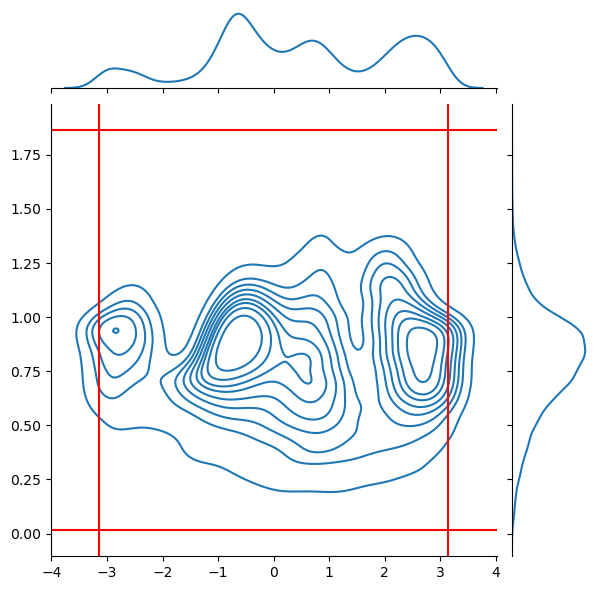

In [13]:
sns.jointplot(x=theta, y=r, kind='kde', palette="Set2")
plt.axvline(x=theta.min(), color='r')
plt.axvline(x=theta.max(), color='r')
plt.axhline(y=r.min(), color='r')
plt.axhline(y=r.max(), color='r')

In [ ]:
# print(np.min(theta), np.max(theta))
# print("-pi", log_intensities[theta == np.min(theta)])
# print("0", log_intensities[np.abs(theta) == np.min(np.abs(theta))])
# print("pi/4", log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4))])
# print("pi/2", log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2))])
# # Shows theta is counter-clockwise

# # plot these on the original data
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(log_intensities[theta == np.min(theta), 0], log_intensities[theta == np.min(theta), 1], c="r")
# plt.scatter(log_intensities[np.abs(theta) == np.min(np.abs(theta)), 0], log_intensities[np.abs(theta) == np.min(np.abs(theta)), 1], c="g")
# plt.scatter(log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4)), 0], log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4)), 1], c="y")
# plt.scatter(log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2)), 0], log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2)), 1], c="b")

-3.141312261673428 3.1414208261514163


In [14]:
from cc_pseudotime import stretch_time

def calculate_pseudotime(pol_data, centered_data, save_dir=""):
    pol_sort_inds = np.argsort(pol_data[1])
    pol_sort_rho = pol_data[0][pol_sort_inds]
    pol_sort_phi = pol_data[1][pol_sort_inds]
    centered_data_sort0 = centered_data[pol_sort_inds, 0]
    centered_data_sort1 = centered_data[pol_sort_inds, 1]

    # Rezero to minimum --resoning, cells disappear during mitosis, so we should have the fewest detected cells there
    bins = plt.hist(pol_sort_phi, 1000)
    start_phi = bins[1][np.argmin(bins[0])]

    # Move those points to the other side
    more_than_start = np.greater(pol_sort_phi, start_phi)
    less_than_start = np.less_equal(pol_sort_phi, start_phi)
    pol_sort_rho_reorder = np.concatenate(
        (pol_sort_rho[more_than_start], pol_sort_rho[less_than_start])
    )
    pol_sort_inds_reorder = np.concatenate(
        (pol_sort_inds[more_than_start], pol_sort_inds[less_than_start])
    )
    pol_sort_phi_reorder = np.concatenate(
        (pol_sort_phi[more_than_start], pol_sort_phi[less_than_start] + np.pi * 2)
    )
    pol_sort_centered_data0 = np.concatenate(
        (centered_data_sort0[more_than_start], centered_data_sort0[less_than_start])
    )
    pol_sort_centered_data1 = np.concatenate(
        (centered_data_sort1[more_than_start], centered_data_sort1[less_than_start])
    )
    pol_sort_shift = pol_sort_phi_reorder + np.abs(np.min(pol_sort_phi_reorder))

    # Shift and re-scale "time"
    # reverse "time" since the cycle goes counter-clockwise wrt the fucci plot
    pol_sort_norm = pol_sort_shift / np.max(pol_sort_shift)
    pol_sort_norm_rev = 1 - pol_sort_norm
    pol_sort_norm_rev = stretch_time(pol_sort_norm_rev)
    pol_unsort = np.argsort(pol_sort_inds_reorder)
    fucci_time = pol_sort_norm_rev[pol_unsort]
    return fucci_time

(33933,)
[0.943 0.819 0.902 ... 0.744 0.078 0.686]


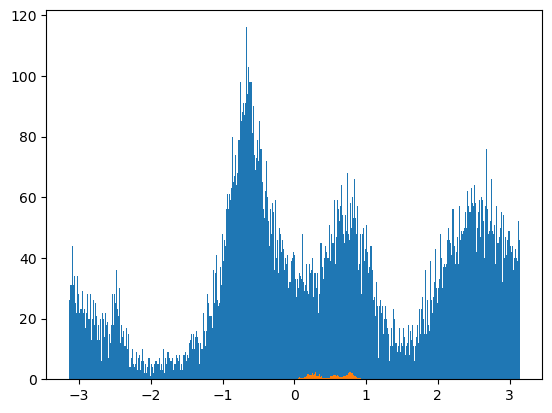

In [15]:
# sort the data by theta
polar = np.stack([r, theta], axis=-1)
fucci_time = calculate_pseudotime(polar.T, centered_intensities)
print(fucci_time.shape)
print(fucci_time)

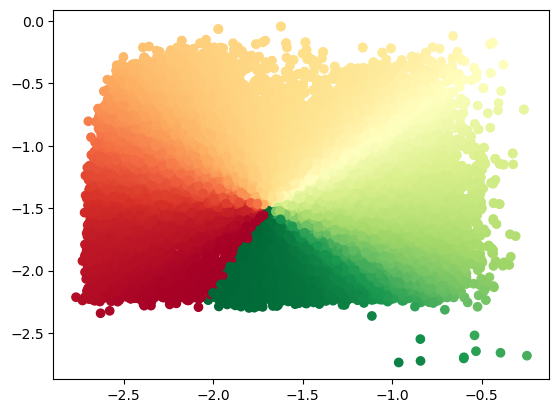

In [16]:
# plot a scatter plot of the log intensities colored by fucci time red to green
plt.scatter(log_intensities[:, 0], log_intensities[:, 1], c=fucci_time, cmap="RdYlGn")

[0.943 0.819 0.902 0.395 0.953 0.12  0.916 0.922 0.117 0.121] [0.257 0.004 0.196 0.47  0.131 0.257 0.332 0.744 0.078 0.686]


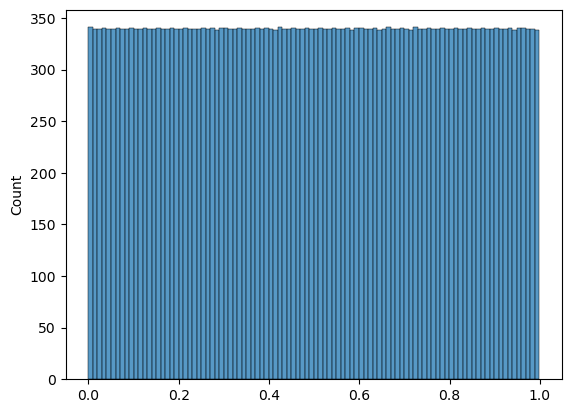

In [18]:
sns.histplot(fucci_time, bins=100)
print(fucci_time[:10], fucci_time[-10:])

In [ ]:
np.save(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy", fucci_time)

0 199


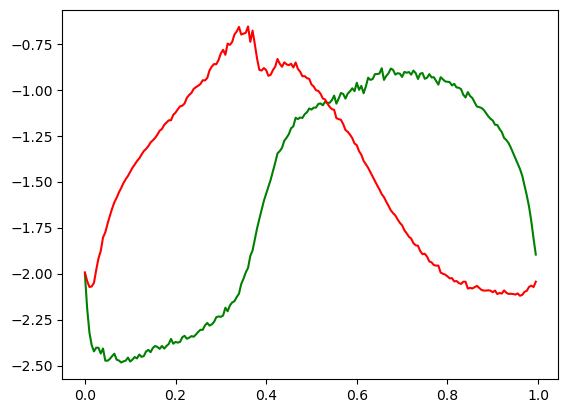

In [9]:
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")
fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")
# plot fucci time vs gmnn and cdt1 intensities
bins = np.linspace(0, 1 + 1e-5, 201)
fucci_bins = np.digitize(fucci_time, bins) - 1
print(fucci_bins.min(), fucci_bins.max())
fucci_gmnn = np.zeros((200,))
fucci_cdt1 = np.zeros((200,))
for i in range(0, len(bins) - 1):
    fucci_gmnn[i] = np.mean(log_intensities[fucci_bins == i, 0])
    fucci_cdt1[i] = np.mean(log_intensities[fucci_bins == i, 1])

plt.plot(bins[:-1], fucci_gmnn, c="g")
plt.plot(bins[:-1], fucci_cdt1, c="r")